#### 1 Introduction
#### 2 Load and check data
2.1 load data \
2.2 Outlier detection \
2.3 joining train and test set \
2.4 check for null and missing values \
#### 3 Feature analysis
3.1 Numerical values \
3.2 Categorical values \
#### 4 Filling missing Values
4.1 Age
#### 5 Feature engineering
5.1 Name/Title \
5.2 Family Size \
5.3 Cabin \
5.4 Ticket \
#### 6 Modeling
6.1 Simple modeling \
6.1.1 Cross validate models \
6.1.2 Hyperparamater tunning for best models \
6.1.3 Plot learning curves \
6.1.4 Feature importance of the tree based classifiers \
6.2 Ensemble modeling \
6.2.1 Combining models \
6.3 Prediction \
6.3.1 Predict and Submit results \

#### 1. Introduction
This is my first kernel at Kaggle. \
I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. \
Firstly, I will display some feature analyses then ill focus on the feature engineering. \
Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

This script follows three main parts:

Feature analysis \
Feature engineering \
Modeling

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

#### 2. Load and check data
2.1 Load data

In [275]:
# Load data
# train = pd.read_csv('~/Desktop/Daeheon/conda/KaggleForMe/Titanic/train.csv')
# test = pd.read_csv('~/Desktop/Daeheon/conda/KaggleForMe/Titanic/train.csv')
train = pd.read_csv('~/Desktop/Daeheon/ECU-Test/KaggleForMe/Titanic/train.csv')
test = pd.read_csv('~/Desktop/Daeheon/ECU-Test/KaggleForMe/Titanic/train.csv')
IDtest = test['PassengerId']

2.2 Oulier detection

In [276]:
# Outlier detection

def detect_outliers(df, n, features) :
    '''
    Takes a datafream df of feature and returns a list of the indices
    correspoding to the observations containing more than n outliers according to the Tukey method
    형상의 데이터 프레임을 사용하고 Tukey 방법에 따라 특이치가 n개 이상 포함된 관측치에 해당하는 인덱스 리스트를 반환합니다
    '''
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartitle (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartitle (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartitle range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        #Determine a list of indices of outlers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)
    
    return multiple_outliers 
# detect outlier from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.

In [277]:
# Show the ouliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare

The 7 others have very high values of SibSP.

In [278]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

2.3 joining train and test set

In [279]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

I join train and test datasets to obtain the same number of features during categorical conversion (See feature engineering).

2.4 check for null and missing values

In [280]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             347
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1367
Embarked          4
dtype: int64

Age and Cabin features have an important part of missing values.

Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)

In [281]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [282]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [283]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


#### 3. Feature analysis
3.1 Numerical values

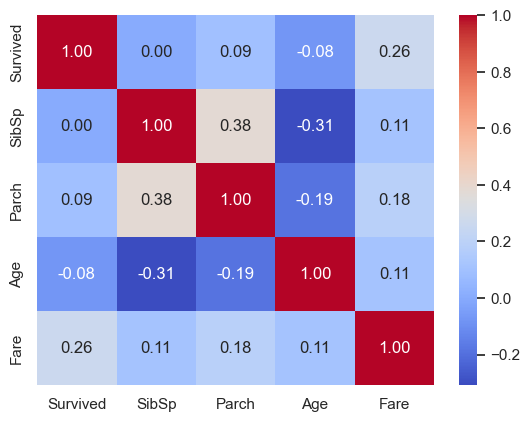

In [284]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

SibSP

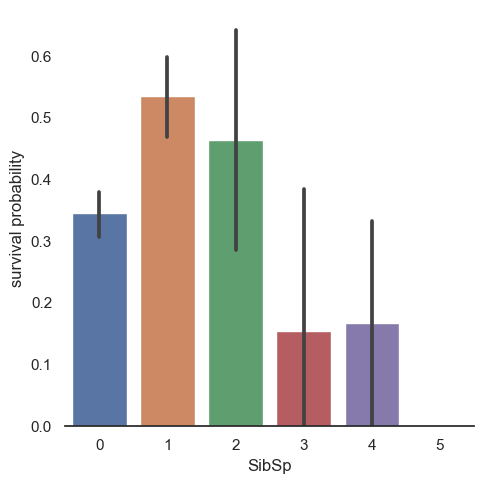

In [285]:
# Explore SibSp feature vs Survived
# g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , palette = "muted")
g = sns.catplot(x="SibSp", y="Survived", data= train, kind= "bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

Parch

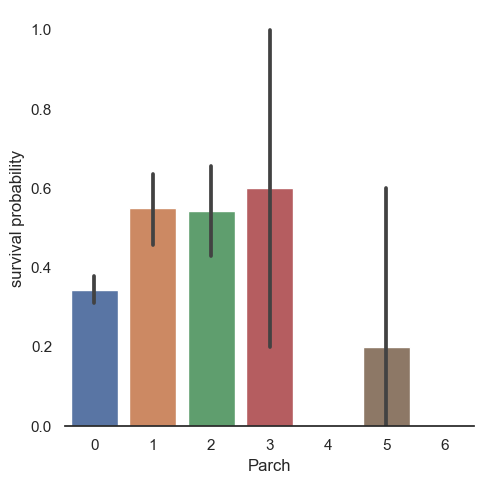

In [286]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=train, kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

Age

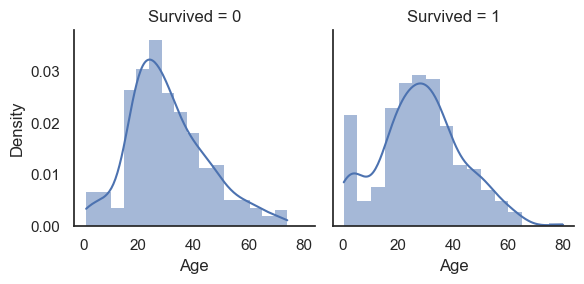

In [287]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
# g = g.map(sns.distplot, "Age")
g = g.map(sns.histplot, "Age",kde=True, stat="density", linewidth=0)

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

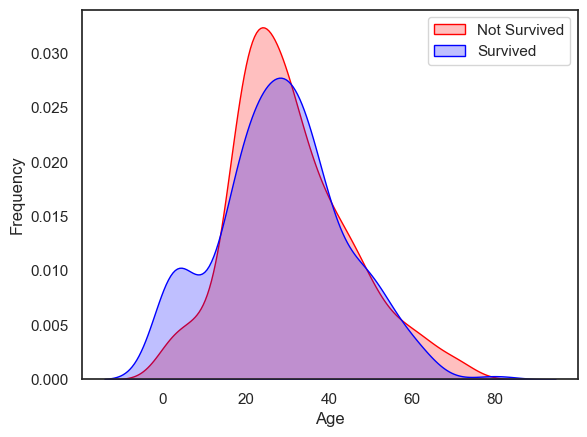

In [288]:
# Explore Age distibution 
# g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
# g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red",fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue",fill = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

Fare

In [289]:
dataset['Fare'].isnull().sum()

0

In [290]:
# Fil Fare missing values with the median value
# median() - 중간번째 값을 도출하는 함수
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

Since we have one missing value , i decided to fill it with the median value which will not have an important effect on the prediction.

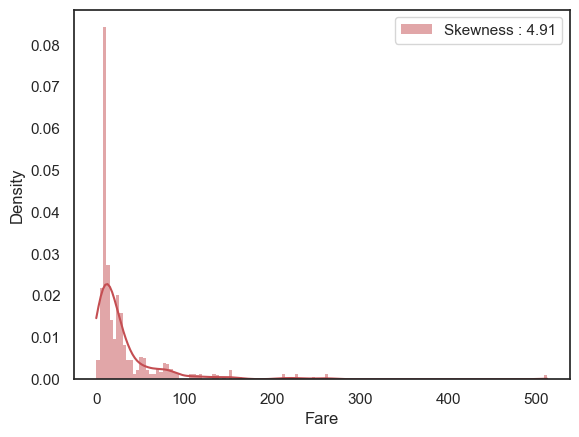

In [291]:
# Explore Fare distribution 
# one of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};
# a hex RGB or RGBA string (e.g., '#0f0f0f' or '#0f0f0f80'; case-insensitive);
g = sns.histplot(dataset["Fare"], color="r", label="Skewness : %.2f"%(dataset["Fare"].skew()), kde=True, stat="density", linewidth=0)
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [292]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

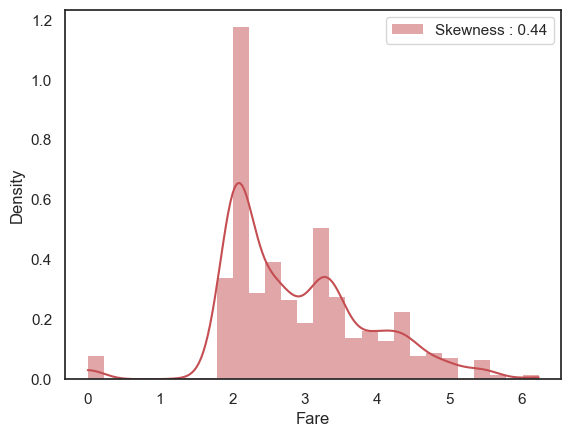

In [293]:
g = sns.histplot(dataset["Fare"], color="r", label="Skewness : %.2f"%(dataset["Fare"].skew()), kde=True, stat="density", linewidth=0)
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation

3.2 Categorical values
Sex

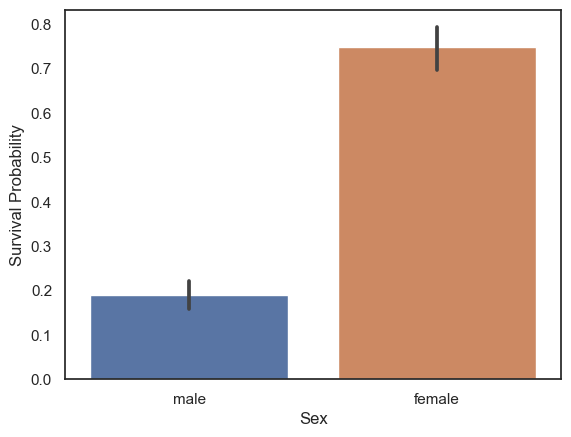

In [294]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [295]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.

So Sex, might play an important role in the prediction of the survival.

For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".

Pclass

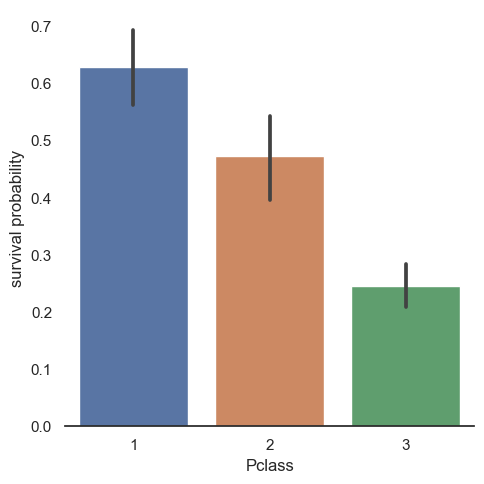

In [296]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

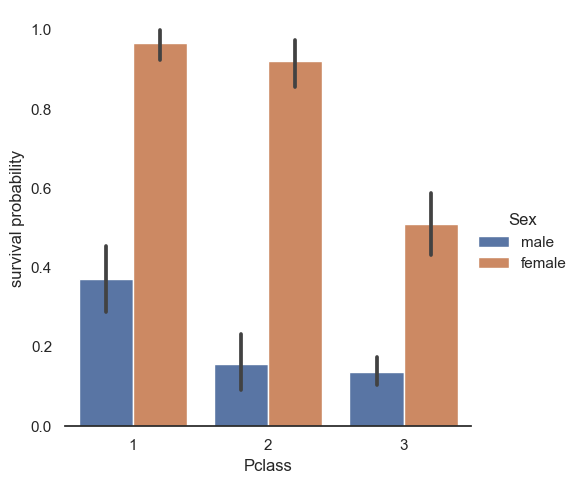

In [297]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female passengers.

Embarked

In [298]:
dataset["Embarked"].isnull().sum()

4

In [299]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).

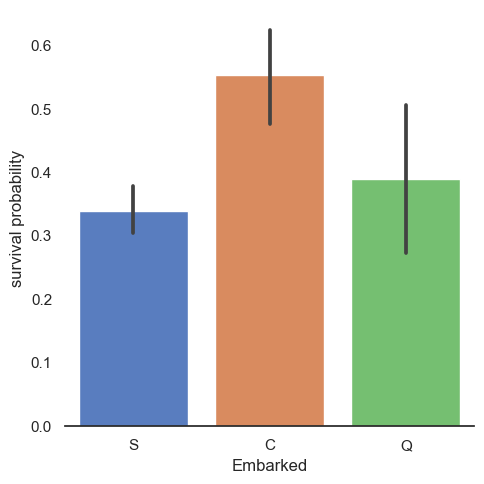

In [300]:
# Explore Embarked vs Survived 
g = sns.catplot(x="Embarked", y="Survived",  data=train,kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

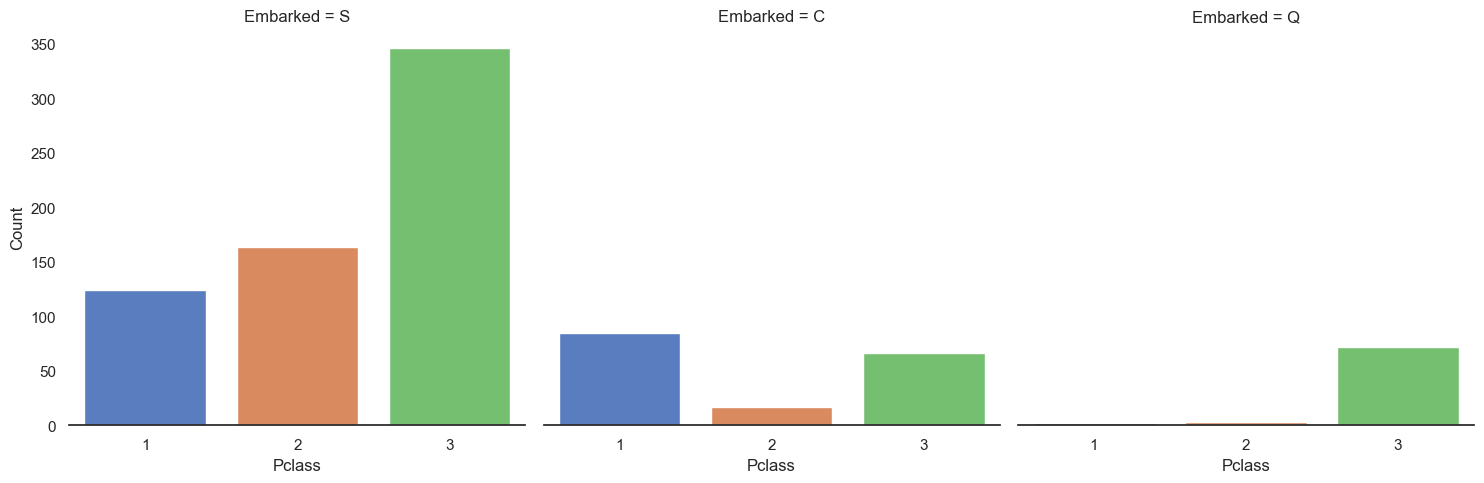

In [301]:
# Explore Pclass vs Embarked 
g = sns.catplot(x="Pclass", col="Embarked",  data=train,kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

#### 4. Filling missing Values
4.1 Age
As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

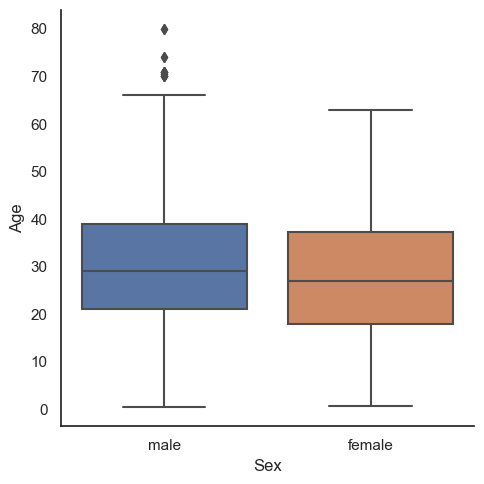

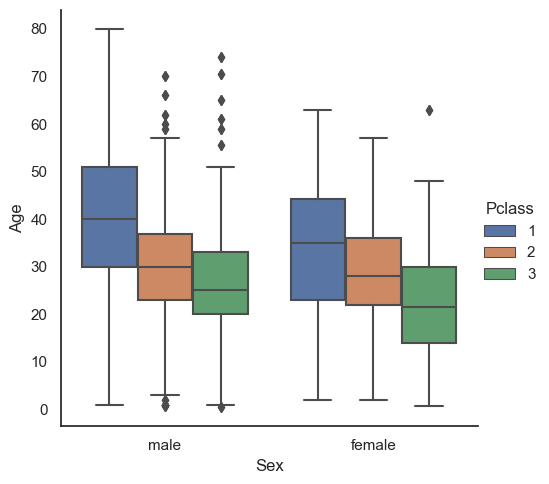

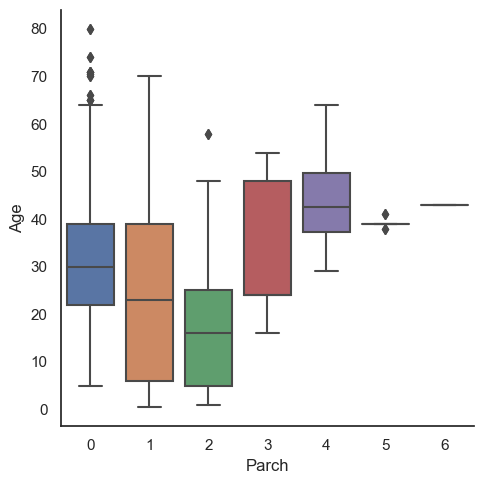

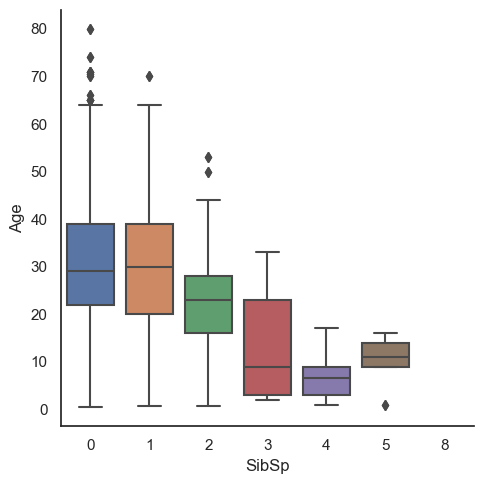

In [302]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [303]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

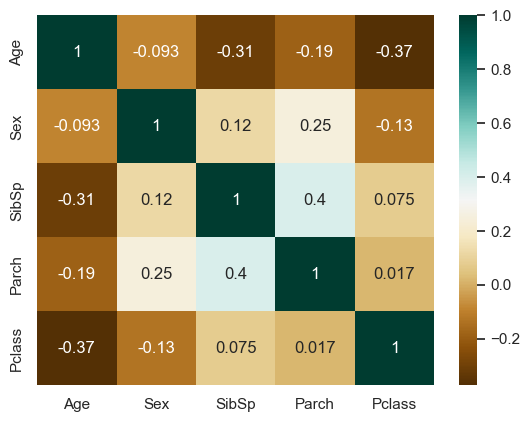

In [304]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [305]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\QXZ3IJB\AppData\Local\Temp\ipykernel_9068\2722654412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\QXZ3IJB\AppData\Local\Temp\ipykernel_9068\2722654412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\QXZ3IJB\AppData\Local\Temp\ipykernel_9068\2722654412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = a

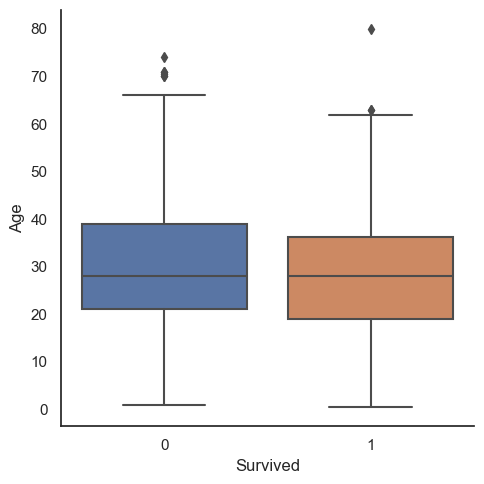

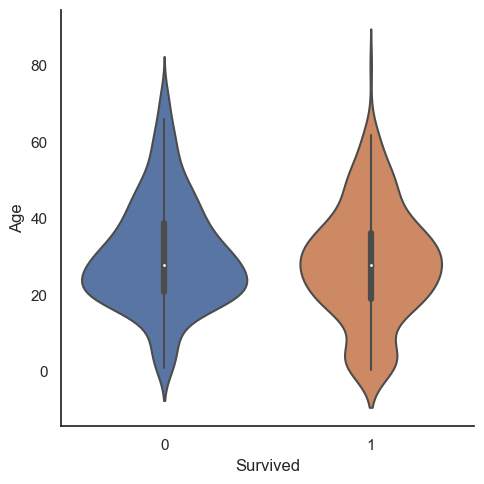

In [306]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

#### 5. Feature engineering
5.1 Name/Title

In [307]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

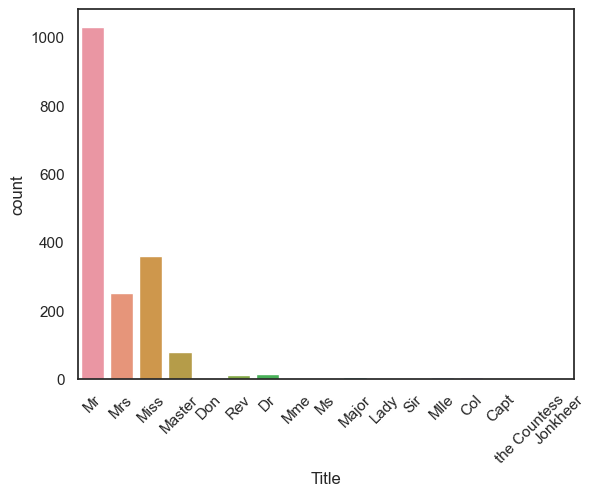

In [308]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [309]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

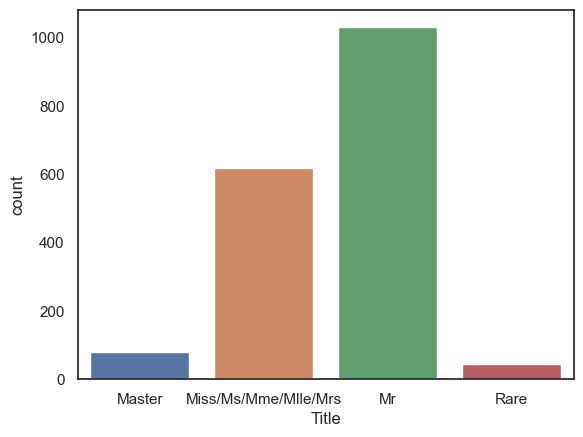

In [310]:
g = sns.countplot(x=dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

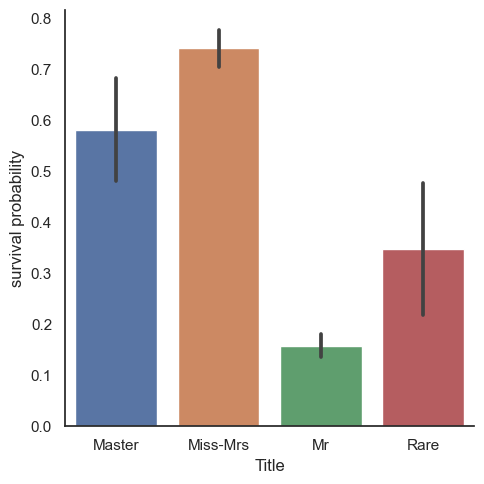

In [311]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Women and children first"

It is interesting to note that passengers with rare title have more chance to survive.

In [312]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

5.2 Family size
We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [313]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

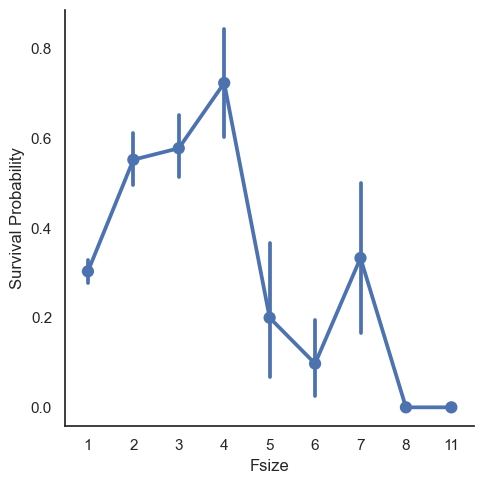

In [314]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset, kind= "point")
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.

Additionally, i decided to created 4 categories of family size.

In [315]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

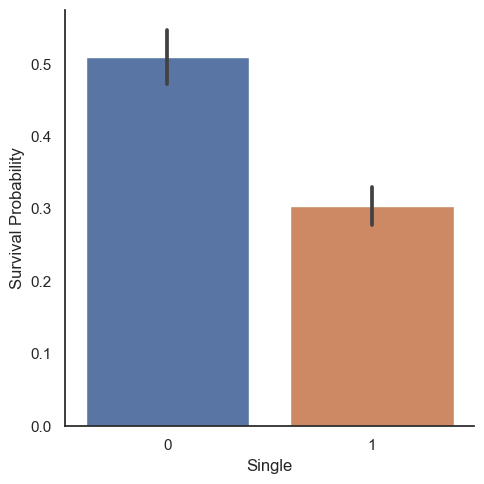

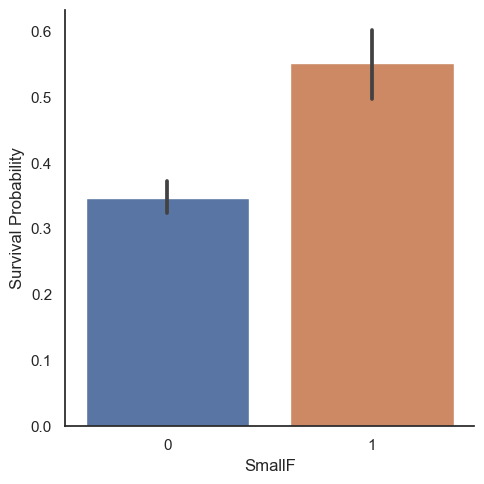

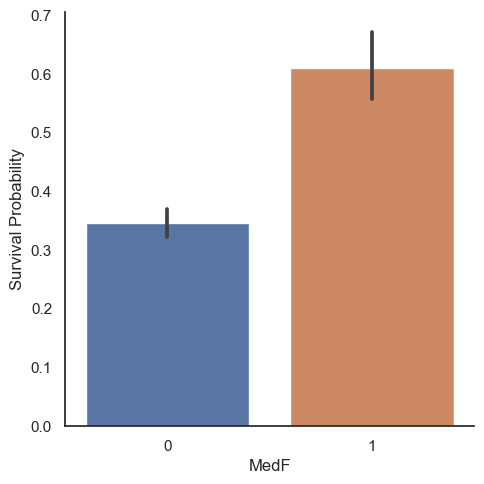

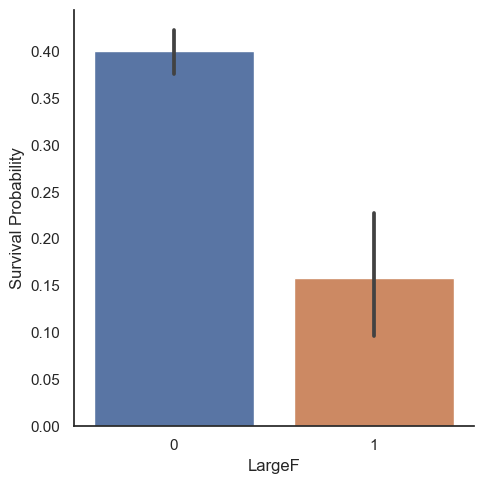

In [316]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [317]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

At this stage, we have 22 features.

5.3 Cabin

In [318]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [319]:
dataset["Cabin"].describe()

count         405
unique        147
top       B96 B98
freq            8
Name: Cabin, dtype: object

In [320]:
dataset["Cabin"].isnull().sum()

1367

The Cabin feature column contains 292 values and 1007 missing values.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [321]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [322]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

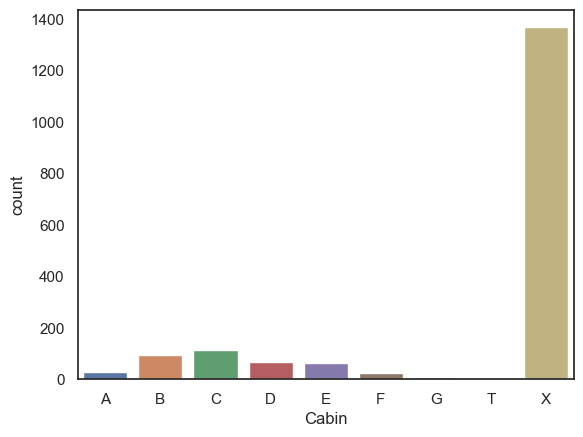

In [323]:
g = sns.countplot(x=dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

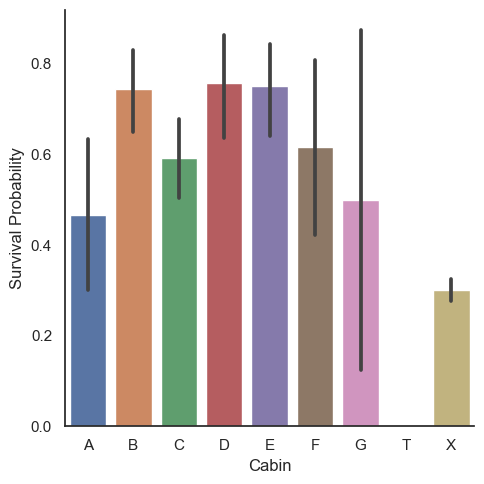

In [324]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [325]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

5.4 Ticket

In [326]:
dataset["Ticket"].head()


0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [327]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [328]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [329]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [330]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [331]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_SP,T_STONO,T_STONO2,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1,1,26.0,0,0,2.070022,1,1,0,0,...,False,False,True,False,False,False,False,False,False,True
3,1,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


#### 6. MODELING

In [332]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\Users\QXZ3IJB\AppData\Local\Temp\ipykernel_9068\1673638405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [333]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

C:\Users\QXZ3IJB\AppData\Local\Temp\ipykernel_9068\3125760867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until

6.1 Simple modeling \
6.1.1 Cross validate models \
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

SVC \
Decision Tree \
AdaBoost \
Random Forest \
Extra Trees \
Gradient Boosting \
Multiple layer perceprton (neural network) \
KNN \
Logistic regression \
Linear Discriminant Analysis